In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Installing Packages/Importing Required Libraries/Loading and Preparing Data

In [2]:
!pip install PyMuPDF tqdm pandas --quiet

import os
import zipfile
import fitz  # PyMuPDF
from tqdm import tqdm
import pandas as pd

# Paths on Google Drive
csv_path = '/content/drive/MyDrive/Indian_judgements/reduced_judgements_clean.csv'
pdf_zip_path = '/content/drive/MyDrive/Indian_judgements/reduced_pdfs.zip'

# Extract ZIP to a folder
extracted_pdf_dir = '/content/reduced_pdfs'
os.makedirs(extracted_pdf_dir, exist_ok=True)

with zipfile.ZipFile(pdf_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_pdf_dir)

print("PDFs extracted to:", extracted_pdf_dir)

# Load CSV
df = pd.read_csv(csv_path)
df['pdf_path'] = df['pdf_path'].apply(lambda x: os.path.join(extracted_pdf_dir, os.path.basename(str(x))))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 117.5 MB/s eta 0:00:00
PDFs extracted to: /content/reduced_pdfs


# Extracting Text from Judgment PDFs

In [3]:
# Filter only existing & non-empty PDFs
df = df[df['pdf_path'].apply(lambda x: os.path.exists(x) and os.path.getsize(x) > 0)].reset_index(drop=True)
print("Total valid PDFs found:", len(df))

# Extract text from PDFs
df['judgements_text'] = ''
for i, row in tqdm(df.iterrows(), total=len(df), desc="Extracting text"):
    pdf_path = row['pdf_path']
    text = ''
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                page_text = page.get_text()
                if page_text:
                    text += page_text + '\n'
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    df.at[i, 'judgements_text'] = text

# Save extracted texts
text_csv_path = '/content/judgements_with_text.csv'
text_parquet_path = '/content/judgements_with_text.parquet'

df.to_csv(text_csv_path, index=False)
df.to_parquet(text_parquet_path, index=False)
print(f"Saved extracted data to CSV & Parquet:\n{text_csv_path}\n{text_parquet_path}")

Total valid PDFs found: 1879


Extracting text: 100%|██████████| 1879/1879 [01:21<00:00, 23.13it/s]


Saved extracted data to CSV & Parquet:
/content/judgements_with_text.csv
/content/judgements_with_text.parquet


# Text Preprocessing and Chunking

In [7]:
!pip install nltk --quiet

import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords
stop_words = set(stopwords.words('english'))
legal_stopwords = {
    'petitioner', 'respondent', 'appellant', 'defendant', 'plaintiff',
    'party', 'parties', 'counsel', 'advocate', 'attorney', 'prosecutor', 'applicant',
    'court', 'bench', 'judgment', 'order', 'proceedings', 'hearing', 'case',
    'matter', 'petition', 'claim', 'verdict', 'decision',
    'filed', 'plea', 'petitioners', 'respondents', 'submitted', 'allowed',
    'dismissed', 'granted', 'rejected', 'challenged', 'reviewed', 'appeal',
    'rights', 'regulation', 'rule', 'statute', 'provision', 'authority',
    'liable', 'responsible', 'application', 'objection', 'record',
    'shall', 'may', 'would', 'could', 'should', 'must', 'might'
}
stop_words.update(legal_stopwords)

lemmatizer = WordNetLemmatizer()
CHUNK_WORDS = 400
OVERLAP = 50

# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'(\w)-(\w)', r'\1 \2', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [w for w in tokens if not w[0].isupper()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.lower() not in stop_words and len(w) > 2]
    tokens = [w for w in tokens if re.fullmatch(r'[a-z]+', w)]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['judgements_text'].apply(preprocess_text)

# Chunking function
def chunk_text_sliding_words(text, chunk_size=CHUNK_WORDS, overlap=OVERLAP):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return []
    words = text.split()
    if len(words) <= chunk_size:
        return [" ".join(words)]
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunks.append(" ".join(words[start:end]))
        if end == len(words):
            break
        start += (chunk_size - overlap)
    return chunks

# Apply chunking
df['text_chunks'] = df['processed_text'].apply(chunk_text_sliding_words)
df_chunks = df.explode('text_chunks').reset_index(drop=True)
df_chunks = df_chunks[['diary_no', 'text_chunks']]
df_chunks = df_chunks[df_chunks['text_chunks'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)].reset_index(drop=True)

print("\nPreprocessing and chunking done! Total chunks:", len(df_chunks))

# Preview first 2 judgments
first_two_diary_nos = df_chunks['diary_no'].unique()[:2]
for diary_no in first_two_diary_nos:
    print(f"\n=== Chunks for Judgment {diary_no} ===\n")
    chunks = df_chunks[df_chunks['diary_no'] == diary_no]['text_chunks'].tolist()
    for i, chunk in enumerate(chunks, 1):
        print(f"--- Chunk {i} ({len(chunk.split())} words) ---")
        print(chunk[:500] + ("..." if len(chunk) > 500 else ""))
        print()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Preprocessing and chunking done! Total chunks: 8231

=== Chunks for Judgment 80384-1991 ===

--- Chunk 1 (400 words) ---
qualification exercise jurisdiction ground incumbent fulfill qualification required dated appointed procedure officer administer justice power analogous judicial hold judicial office judiciary justice assume jurisdiction judicial side probe purely administrative nature exclusively within purview serviceinterpretation letter dated addressed recommended name appointment bio data enclosed said letter indicated passing joined worked various post law appointed worked also worked certain bio data desc...

--- Chunk 2 (400 words) ---
eligible appointed mockery hold eligible appointed scheme clear independence judiciary part basic structure achieve objective separation judiciary executive framer meant judicial office exist independently duty part duty conferred person whether trained administration justice enshrined give mandate take step separate judiciary executive mean s

# Legal-Bert Modeling on Legal Texts

In [9]:
# Install sentence-transformers if not already
!pip install -q sentence-transformers

import torch
from sentence_transformers import SentenceTransformer

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load pretrained Legal-BERT
model_name = "nlpaueb/legal-bert-base-uncased"
embedder = SentenceTransformer(model_name, device=device)

# Prepare text chunks safely
texts = df_chunks['text_chunks'].tolist()
texts = [str(t) for t in texts if isinstance(t, str) and len(t.strip()) > 0]
print("Total chunks to encode:", len(texts))

# Set batch size (adjust if GPU memory allows)
batch_size = 32

# Encode embeddings
embeddings = embedder.encode(
    texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True  # returns a NumPy array
)

print("Embeddings generated. Shape:", embeddings.shape)


Using device: cuda
Total chunks to encode: 8231


Batches:   0%|          | 0/258 [00:00<?, ?it/s]

Embeddings generated. Shape: (8231, 768)


In [10]:
print("Embedding of first chunk:\n", embeddings[0])
print("Embedding shape:", embeddings[0].shape)


Embedding of first chunk:
 [ 8.49337727e-02  3.51875991e-01  5.57594121e-01 -3.63238990e-01
  2.90524006e-01  1.64880157e-02  2.48618219e-02  8.50118622e-02
 -3.16241458e-02 -2.53500223e-01  2.40705665e-02  1.10580996e-02
 -1.49268597e-01 -4.42783274e-02  1.80034451e-02  3.75721812e-01
  5.69689944e-02 -1.19077019e-01 -2.99050391e-01  2.98155993e-01
  6.53023124e-01 -2.23270734e-03 -8.58245883e-03  1.89364135e-01
 -6.54276907e-02  2.23491237e-01 -2.59250905e-02 -2.46503547e-01
 -2.04385445e-01 -1.06718041e-01  3.23409140e-01 -3.14805537e-01
  5.35383940e-01 -1.95427567e-01  2.66415864e-01 -2.73342162e-01
  6.47946224e-02  1.44740660e-02  3.22054952e-01  1.05343066e-01
  4.18567687e-01 -4.61374402e-01  3.03167909e-01 -1.29585043e-01
 -4.67914551e-01 -8.05696473e-02 -2.25019887e-01 -2.99329162e-01
 -6.66418076e-02  5.95447198e-02 -2.28396550e-01 -2.78324783e-02
 -3.84822190e-01 -7.46705234e-02  1.57391995e-01  2.09074259e-01
 -5.76662757e-02 -7.15209022e-02 -3.51102531e-01  5.64726815e-0

In [12]:
import numpy as np
np.save("/content/legal_bert_embeddings.npy", embeddings)
print("Embeddings saved to /content/legal_bert_embeddings.npy")

Embeddings saved to /content/legal_bert_embeddings.npy


# K-Means CLustering

In [42]:

# Load embeddings
import numpy as np
embeddings = np.load("/content/legal_bert_embeddings.npy")
print("Embeddings loaded:", embeddings.shape)


#  KMeans clustering
from sklearn.cluster import KMeans
import pandas as pd

# Number of legal categories
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# df_chunks should have: ['diary_no', 'text_chunks']
df_chunks['cluster'] = cluster_labels


Embeddings loaded: (8231, 768)


In [43]:
for c in range(n_clusters):
    print(f"\n=== Cluster {c} ===")
    sample_texts = df_chunks[df_chunks['cluster'] == c]['text_chunks'].head(3).tolist()  # show first 3 chunks
    for t in sample_texts:
        print(t[:300], "...\n")  # show first 300 character


=== Cluster 0 ===
maze fact event labyrinth legal conundrum confront course determination ambit sweep principle re judicata centre controversy brevity enshrines another complexion re judicata also requires cogitated upon contention hereafter referred brevity demised property barred principle re judicata challenging f ...

without touching upon legal character suit property well legal propriety capacity transfer attracted question subsequently raised event new owner namely bring action law reason unable agree determination central therefore re judicata apply despite failure cannot sustain dismissal nay even necessity  ...

resulting filing sole central issue canvassed whether right divert flow water land fishing purpose barred re judicata answered affirmative concluded filing appeal decree passed appeal arising suit become final conclusive observed appealed reopened second arising appellant suit issue whether easement ...


=== Cluster 1 ===
eligible appointed mockery hold eligible app

# Mapping CLusters to Law Categories

In [44]:

# Map clusters to legal categories

cluster_to_category = {
    0: 'Civil Law',
    1: 'Administrative/Service Law',
    2: 'Criminal Law',
    3: 'Tax/Corporate Law',
    4: 'Labor/Employment Law',
    5: 'Administrative/Service Law'
}

df_chunks['predicted_category'] = df_chunks['cluster'].map(cluster_to_category)


#  Aggregate to judgment level (majority vote)
judgment_predictions = (
    df_chunks.groupby('diary_no')['predicted_category']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)


# Save predictions

judgment_predictions.to_csv("/content/kmeans_judgment_predictions.csv", index=False)
print("✅ Saved predictions to 'kmeans_judgment_predictions.csv'")


#  Check distribution
print("\nCategory distribution:")
print(judgment_predictions['predicted_category'].value_counts())


✅ Saved predictions to 'kmeans_judgment_predictions.csv'

Category distribution:
predicted_category
Administrative/Service Law    525
Civil Law                     477
Criminal Law                  321
Tax/Corporate Law             251
Labor/Employment Law          231
Name: count, dtype: int64


In [45]:
# Preview first few judgments with predicted category
print("\nPreview of diary numbers with predicted categories:")
print(judgment_predictions[['diary_no', 'predicted_category']].head(10))



Preview of diary numbers with predicted categories:
     diary_no          predicted_category
0          -0                Criminal Law
1       -1428  Administrative/Service Law
2      1-1148                   Civil Law
3      1-1918  Administrative/Service Law
4      1-9098           Tax/Corporate Law
5      1-9228                   Civil Law
6    100-1961           Tax/Corporate Law
7  10044-2000                   Civil Law
8  10045-2004  Administrative/Service Law
9  10049-1994  Administrative/Service Law


/tmp/ipython-input-2207761697.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_category', data=judgment_predictions, palette='tab10')


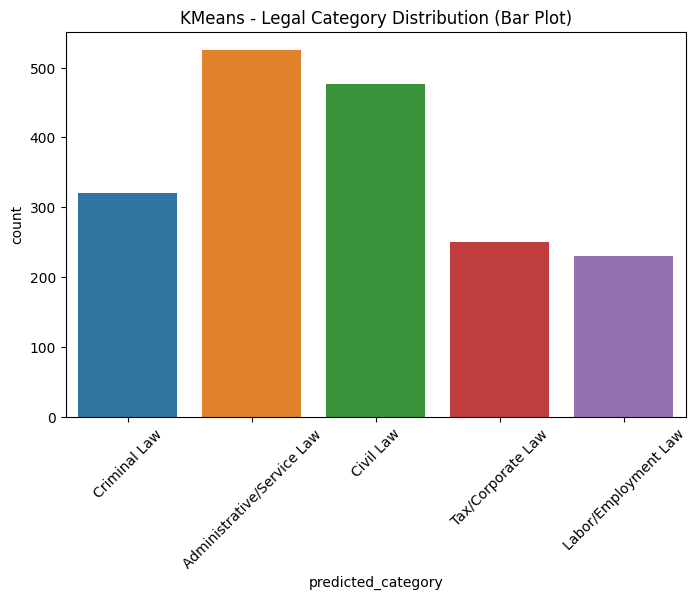

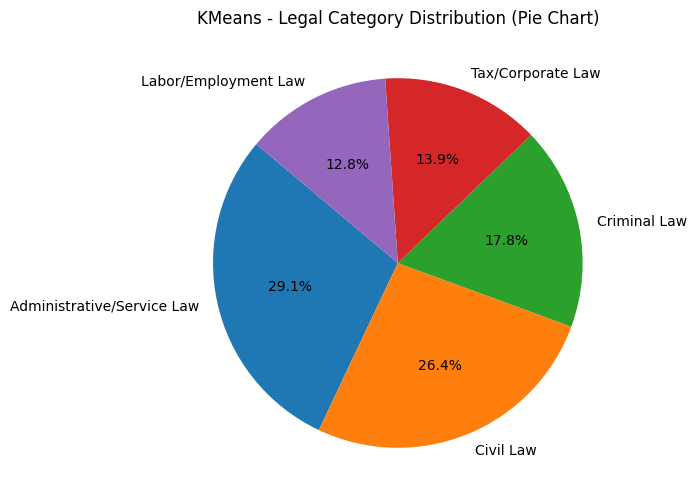

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


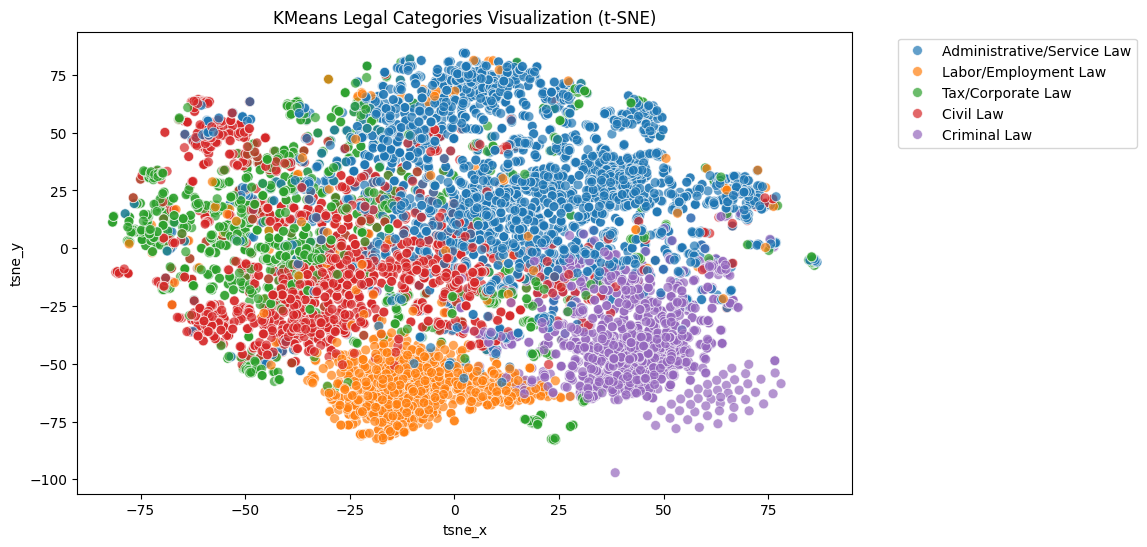

Category: Criminal Law, Sample diary numbers: ['-0', '10056-2001', '10172-2000']
Category: Administrative/Service Law, Sample diary numbers: ['-1428', '1-1918', '10045-2004']
Category: Civil Law, Sample diary numbers: ['1-1148', '1-9228', '10044-2000']
Category: Tax/Corporate Law, Sample diary numbers: ['1-9098', '100-1961', '10283-1994']
Category: Labor/Employment Law, Sample diary numbers: ['10055-2008', '10111-1994', '10386-1994']
Silhouette Score: 0.048
Davies-Bouldin Score: 3.457


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score

plt.figure(figsize=(8,5))
sns.countplot(x='predicted_category', data=judgment_predictions, palette='tab10')
plt.title("KMeans - Legal Category Distribution (Bar Plot)")
plt.xticks(rotation=45)
plt.show()

category_counts = judgment_predictions['predicted_category'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('tab10'))
plt.title("KMeans - Legal Category Distribution (Pie Chart)")
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
df_chunks['tsne_x'] = embeddings_2d[:, 0]
df_chunks['tsne_y'] = embeddings_2d[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='predicted_category', data=df_chunks, palette='tab10', alpha=0.7, s=50)
plt.title("KMeans Legal Categories Visualization (t-SNE)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

for cat in judgment_predictions['predicted_category'].unique():
    sample_diaries = judgment_predictions[judgment_predictions['predicted_category']==cat]['diary_no'].head(3).tolist()
    print(f"Category: {cat}, Sample diary numbers: {sample_diaries}")

sil_score = silhouette_score(embeddings, df_chunks['cluster'])
db_score = davies_bouldin_score(embeddings, df_chunks['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")


# HDBSCAN

In [46]:
!pip install -q hdbscan

import hdbscan
import numpy as np


In [37]:
# --- Later: Load embeddings ---
loaded_embeddings = np.load("/content/legal_bert_embeddings.npy")
print("✅ Embeddings loaded, shape:", loaded_embeddings.shape)

# --- HDBSCAN clustering example ---
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(loaded_embeddings)

print("Clusters found (excluding noise):", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
print("Number of noise points (-1):", np.sum(cluster_labels == -1))



✅ Embeddings loaded, shape: (8231, 768)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found (excluding noise): 5
Number of noise points (-1): 7764


In [36]:
import pandas as pd

# --- Step 1: Map clusters to your legal categories ---
# Adjust this mapping based on your inspection
cluster_to_category = {
    -1: 'Administrative/Service Law',  # HDBSCAN noise cluster here seems mostly admin
     0: 'Miscellaneous/Noise',        # gibberish / OCR errors
     1: 'Tax/Corporate Law',
     2: 'Civil Law',
     3: 'Labor/Employment Law',
     4: 'Constitutional Law',
     5: 'Criminal Law',
     6: 'Criminal Law'
}

# --- Step 2: Assign category to each chunk ---
df_chunks['predicted_category'] = df_chunks['cluster'].map(cluster_to_category)

# --- Step 3: Aggregate to judgment level (majority vote) ---
judgment_predictions = (
    df_chunks.groupby('diary_no')['predicted_category']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# --- Step 4: Save the results ---
judgment_predictions.to_csv("hdbscan_judgment_predictions.csv", index=False)
print("✅ Saved judgment-level predictions to 'hdbscan_judgment_predictions.csv'")

# --- Step 5: Check distribution of categories ---
print("\nCategory distribution:")
print(judgment_predictions['predicted_category'].value_counts())


✅ Saved judgment-level predictions to 'hdbscan_judgment_predictions.csv'

Category distribution:
predicted_category
Administrative/Service Law    1787
Labor/Employment Law             6
Miscellaneous/Noise              5
Constitutional Law               5
Criminal Law                     2
Name: count, dtype: int64


In [18]:
df_chunks['cluster'] = cluster_labels

# Example: see top chunks from each cluster
for c in np.unique(cluster_labels):
    print(f"\n=== Cluster {c} ===\n")
    sample_texts = df_chunks[df_chunks['cluster']==c]['text_chunks'].head(3).tolist()
    for t in sample_texts:
        print(t[:300], "...\n")



=== Cluster -1 ===

qualification exercise jurisdiction ground incumbent fulfill qualification required dated appointed procedure officer administer justice power analogous judicial hold judicial office judiciary justice assume jurisdiction judicial side probe purely administrative nature exclusively within purview ser ...

eligible appointed mockery hold eligible appointed scheme clear independence judiciary part basic structure achieve objective separation judiciary executive framer meant judicial office exist independently duty part duty conferred person whether trained administration justice enshrined give mandate  ...

chief acknowledged receipt recommendation stated take necessary action immediately formation succeeded addressed detailed letter dated recommending appointment recommendation enclosed bio data address year belongs legal practice translation consultation official language tender legal advice look tax ...


=== Cluster 0 ===

mppre vkijkfkd vihyh kskfkdkjkurxzr vkijk

In [16]:
import pandas as pd
import numpy as np

cluster_to_category = {
    -1: 'Miscellaneous/Noise',             # optional, for noise points
    0: 'Civil Law',
    1: 'Civil Law',
    2: 'Criminal Law',
    3: 'Civil Law',
    4: 'Administrative/Service Law',
    5: 'Tax/Corporate Law',
    6: 'Labor/Employment Law',
    7: 'Administrative/Service Law',
    8: 'Labor/Employment Law',
    9: 'Civil Law',
    10: 'Administrative/Service Law',
    11: 'Civil Law',
    12: 'Criminal Law',
    13: 'Criminal Law',
    14: 'Tax/Corporate Law'  # if cluster 14 exists
}

df_chunks['predicted_category'] = df_chunks['cluster'].map(cluster_to_category)


# Majority vote per judgment
judgment_predictions = df_chunks.groupby('diary_no')['predicted_category'] \
                                .agg(lambda x: x.value_counts().idxmax()) \
                                .reset_index()

# Preview results
print("Sample judgment-level predictions:")
print(judgment_predictions.head())

judgment_predictions.to_csv("judgment_level_predictions.csv", index=False)
print("\nJudgment-level predictions saved to 'judgment_level_predictions.csv'")


Sample judgment-level predictions:
  diary_no   predicted_category
0       -0         Criminal Law
1    -1428  Miscellaneous/Noise
2   1-1148  Miscellaneous/Noise
3   1-1918  Miscellaneous/Noise
4   1-9098  Miscellaneous/Noise

Judgment-level predictions saved to 'judgment_level_predictions.csv'
